In [125]:
import numpy as np
import pandas as pd
from sklearn import linear_model, svm, metrics
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble.partial_dependence import plot_partial_dependence
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
from matplotlib import pyplot as plt
from IPython.display import HTML
import missingno as msno
%matplotlib inline
import seaborn as sns
sns.set(style="whitegrid", color_codes=True)

In [126]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
The raw code for this IPython notebook is by default hidden for easier reading.
To toggle on/off the raw code, click <a href="javascript:code_toggle()">here</a>.''')


# <font color='blue'>Driver Signup Analysis for Ridesharing</font> 

This is a synthetic dataset for ridesharing that shows the details of driver sign-up data. The data consists of when the drivers signed up, the city, sign-up OS, sign-up channel (paid, referred, etc.). Once they signed up for the driving, they are requested to be available for background check, add their vehicle and once those stages are cleared, they are then allowed to start picking up passengers.

Here, the company wants to maximize the trips taken by the drivers. There may be several hurdles before first trip is taken, such as, the background check may be negative, or the drivers may fail to add their vehicle, and so on. This data analysis will try to find the important factors that is involved in the first trip taken by the drivers. And consequently, some recommendations are suggested based on the analysis.

## Read the driver sign up data

Pandas package is used to read the CSV file. As the first step, the columns and data types present in the data frame is examined.

In [127]:
driver_data_raw = pd.read_csv('driversignup.csv')

In [128]:
driver_data_raw.head()

,id,city_name,signup_os,signup_channel,signup_date,bgc_date,vehicle_added_date,vehicle_make,vehicle_model,vehicle_year,first_completed_date
0,1,Strark,ios web,Paid,1/2/16,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Strark,windows,Paid,1/21/16,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Wrouver,windows,Organic,1/11/16,1/11/16,NaN,NaN,NaN,NaN,NaN
3,4,Berton,android web,Referral,1/29/16,2/3/16,2/3/16,Toyota,Corolla,2016.0,2/3/16
4,5,Strark,android web,Referral,1/10/16,1/25/16,1/26/16,Hyundai,Sonata,2016.0,NaN


The next step is to examine the data types in the dataset.

In [129]:
driver_data_raw.dtypes

id                        int64
city_name                object
signup_os                object
signup_channel           object
signup_date              object
bgc_date                 object
vehicle_added_date       object
vehicle_make             object
vehicle_model            object
vehicle_year            float64
first_completed_date     object
dtype: object

There are a few columns where we see the information given in dates--such as the driver sign up date, background check data, etc. But, they are all given as characters. These will not be useful as it is, so they need to be converted into date form so that we can extract meaningful information from them.

In [130]:
driver_data_raw['signup_date'] = pd.to_datetime(driver_data_raw['signup_date'], format="%m/%d/%y")
driver_data_raw['bgc_date'] = pd.to_datetime(driver_data_raw['bgc_date'], format="%m/%d/%y")
driver_data_raw['vehicle_added_date'] = pd.to_datetime(driver_data_raw['vehicle_added_date'], format="%m/%d/%y")
driver_data_raw['first_completed_date'] = pd.to_datetime(driver_data_raw['first_completed_date'], format="%m/%d/%y")

In [131]:
#driver_data_raw.dtypes

In [132]:
df = driver_data_raw

## Feature Engineering

Then, the date variables are converted to respective difference of days from the sign-up date. I also want to see whether the fact that the driver signed up for the trip, or added the vehicle for the trip, etc. has an effect on the model. So a boolean variable is created based on whether there is a value for the number of days for these respective dates.

In [133]:
df['days_bgc'] = df['bgc_date'] - df['signup_date'] 
df['days_vehicle_added'] = df['vehicle_added_date'] - df['signup_date'] 
df['days_first_trip'] = df['first_completed_date'] - df['signup_date']

In [134]:
df['Signed_up'] = np.where(pd.isnull(df['signup_date']), 0, 1)
df['Vehicle_added'] = np.where(pd.isnull(df['vehicle_added_date']), 0, 1)
df['BGC_done'] = np.where(pd.isnull(df['bgc_date']), 0, 1)
df['Trip_taken'] = np.where(pd.isnull(df['first_completed_date']), 0, 1)

In [135]:
df = df.drop(['signup_date', 'bgc_date', 'vehicle_added_date', 'first_completed_date'], axis=1)

In [136]:
df.head()

,id,city_name,signup_os,signup_channel,vehicle_make,vehicle_model,vehicle_year,days_bgc,days_vehicle_added,days_first_trip,Signed_up,Vehicle_added,BGC_done,Trip_taken
0,1,Strark,ios web,Paid,NaN,NaN,NaN,NaT,NaT,NaT,1,0,0,0
1,2,Strark,windows,Paid,NaN,NaN,NaN,NaT,NaT,NaT,1,0,0,0
2,3,Wrouver,windows,Organic,NaN,NaN,NaN,0 days,NaT,NaT,1,0,1,0
3,4,Berton,android web,Referral,Toyota,Corolla,2016.0,5 days,5 days,5 days,1,1,1,1
4,5,Strark,android web,Referral,Hyundai,Sonata,2016.0,15 days,16 days,NaT,1,1,1,0


The number of days (in 'days' format) is converted to float type.

In [137]:
df['days_first_trip'] = df['days_first_trip'].dt.days
df['days_vehicle_added'] = df['days_vehicle_added'].dt.days
df['days_bgc'] = df['days_bgc'].dt.days

In [138]:
df.head()

,id,city_name,signup_os,signup_channel,vehicle_make,vehicle_model,vehicle_year,days_bgc,days_vehicle_added,days_first_trip,Signed_up,Vehicle_added,BGC_done,Trip_taken
0,1,Strark,ios web,Paid,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0
1,2,Strark,windows,Paid,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0
2,3,Wrouver,windows,Organic,NaN,NaN,NaN,0.0,NaN,NaN,1,0,1,0
3,4,Berton,android web,Referral,Toyota,Corolla,2016.0,5.0,5.0,5.0,1,1,1,1
4,5,Strark,android web,Referral,Hyundai,Sonata,2016.0,15.0,16.0,NaN,1,1,1,0


## Missing Values

As the next step, the missing values should be imputed before we run the model on this dataset. missingno package is used to visualize the missing data in this dataset.

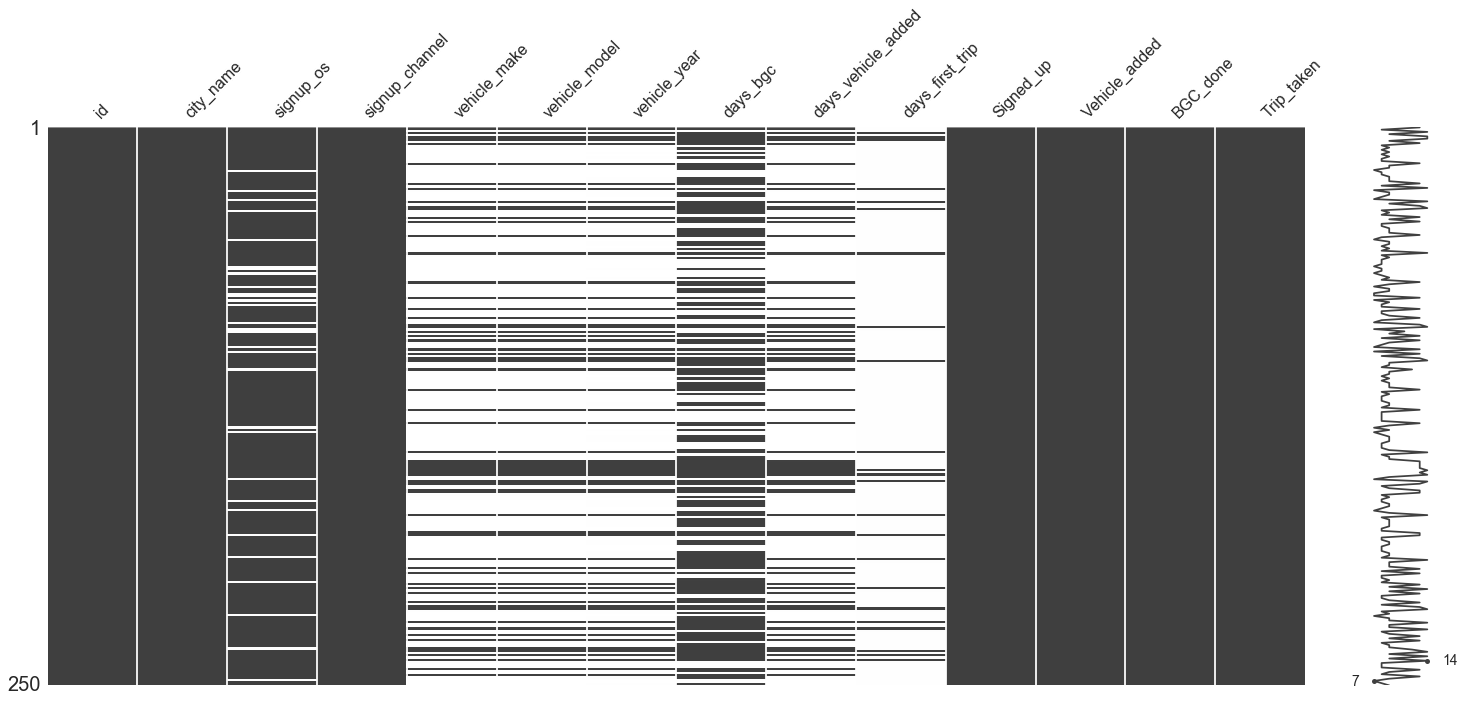

In [139]:
msno.matrix(df.sample(250))

We can see that vehicle attribute values have a lot of missing data in the set. This could be because the drivers did not add their vehicles. But, since they have a lot of missing values, it might not be useful to impute them or include them in the model, as these will lead to biased results (due to imputing). 

For the rest of the categorical features, they could be imputed with mode of the data. For dates, in this case, it means that the driver has not taken that action. So we could impute with a known number (eg. -99).

In [140]:
df_cat = df[['city_name', 'signup_os', 'signup_channel']]
df_num = df[['days_bgc', 'days_vehicle_added', 'days_first_trip', 
             'Signed_up', 'Vehicle_added', 'BGC_done', 'Trip_taken' ]]

In [141]:
df_mode_val = np.array(df_cat.mode())
df_mode_num = np.array(df_num.mode())

In [142]:
df_cat = df_cat.copy() # To avoid setting errors
df_num = df_num.copy()

In [143]:
df_cat['city_name'] = df_cat['city_name'].fillna(df_mode_val[0,0])
df_cat['signup_os'] = df_cat['signup_os'].fillna(df_mode_val[0,1])
df_cat['signup_channel'] = df_cat['signup_channel'].fillna(df_mode_val[0,2])

In [144]:
df_num['days_bgc'] = df_num['days_bgc'].fillna(-99)
df_num['days_vehicle_added'] = df_num['days_vehicle_added'].fillna(-99)
df_num['days_first_trip'] = df_num['days_first_trip'].fillna(-99)

In [145]:
new_df = pd.concat([df_cat, df_num],axis=1 )

The new dataframe after imputing the values is shown here.

In [146]:
new_df.head()

,city_name,signup_os,signup_channel,days_bgc,days_vehicle_added,days_first_trip,Signed_up,Vehicle_added,BGC_done,Trip_taken
0,Strark,ios web,Paid,-99.0,-99.0,-99.0,1,0,0,0
1,Strark,windows,Paid,-99.0,-99.0,-99.0,1,0,0,0
2,Wrouver,windows,Organic,0.0,-99.0,-99.0,1,0,1,0
3,Berton,android web,Referral,5.0,5.0,5.0,1,1,1,1
4,Strark,android web,Referral,15.0,16.0,-99.0,1,1,1,0


## Exploratory Analysis

### Distribution of signup_os, signup_channel, and city signups

Check if the dataset is uneven. This is important while training the model. We can see that the drivers taking the first trip are very low compared to those who are not taking the first trip.

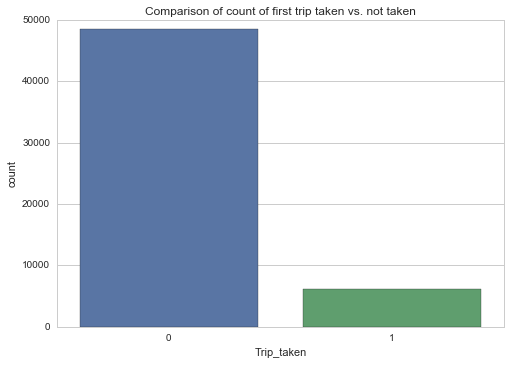

In [147]:
ax = plt.axes()
sns.countplot(x="Trip_taken", data=new_df);
ax.set_title('Comparison of count of first trip taken vs. not taken')
plt.show()

Next step is to see the count of drivers based on signup_os and signup_channel. It is found that most drivers are paid to signup, and most drivers signed up through ios_web.

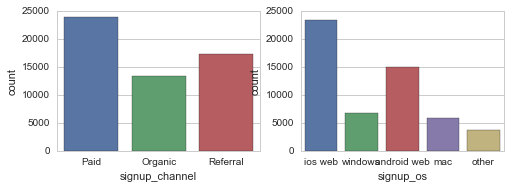

In [148]:
fig = plt.figure()
ax1 = fig.add_subplot(221)
ax2 = fig.add_subplot(222)
sns.countplot(x="signup_channel", data=new_df, ax=ax1);
sns.countplot(x="signup_os", data=new_df, ax=ax2);
plt.show()

However, when we see the plot of trip taken vs. sign_channel, it is interesting to see that most drivers who sign up based on referral tend to take the first trip, followed by organic drivers, and only a few drivers from paid channel take their first trip. 

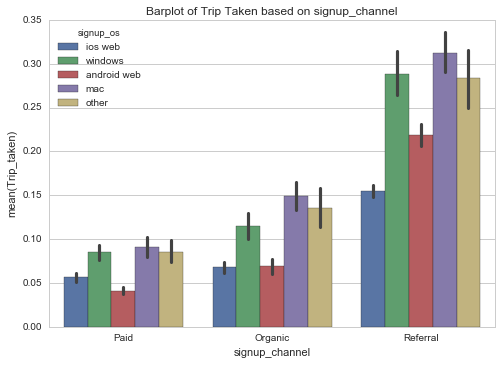

In [149]:
fig = plt.figure()
ax=plt.axes()
sns.barplot(x="signup_channel", y="Trip_taken", hue="signup_os", data=new_df);
ax.set_title('Barplot of Trip Taken based on signup_channel')
plt.show()

The signup OS does not seem to have a huge impact on the trip taken value.

Then we look at the fictional cities, whether it has an effect on the drivers' first trip rate. It seems most drivers hail from Strark city, but there does not seem to be any trend at this point.

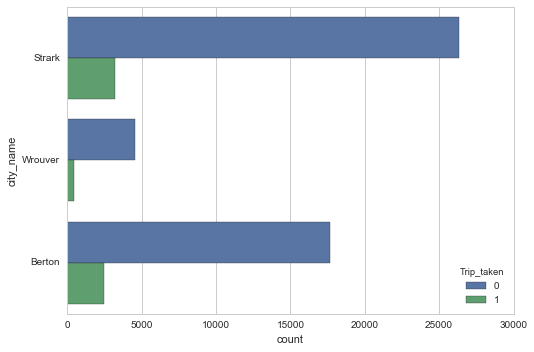

In [150]:
sns.countplot(y="city_name", hue="Trip_taken", data=new_df);

These two following graphs show the distribution of number of days of vehicle added and trip taken from the date of sign up. Vehicle added dates have a skewed distribution, whereas, the first trip taken tend to have a broader tail.

In [221]:
x = new_df[new_df['days_first_trip'] > 0]
x = x[x['days_vehicle_added']>0]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12252cd30>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1225a7ac8>]], dtype=object)

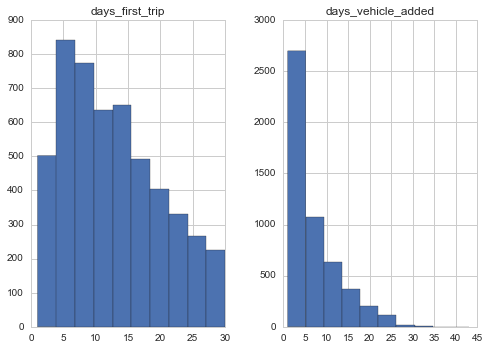

In [222]:
x.hist(column=['days_vehicle_added', 'days_first_trip'])

## Encoding Labels

First, the categorical values in the dataframe need to be converted to labels before we train them and fit a model. 

In [153]:
new_df.dtypes

city_name              object
signup_os              object
signup_channel         object
days_bgc              float64
days_vehicle_added    float64
days_first_trip       float64
Signed_up               int64
Vehicle_added           int64
BGC_done                int64
Trip_taken              int64
dtype: object

In [154]:
train_categorical_values = np.array(new_df[['city_name', 'signup_os', 
                                        'signup_channel']])

Label Encoder is used to convert the categorical values into respective numerical variables.

In [155]:
le = LabelEncoder()
coded_df = le.fit_transform(train_categorical_values[:,0])

In [156]:
for i in range(1, train_categorical_values.shape[1]):
    coded_df = np.column_stack((coded_df, le.fit_transform(train_categorical_values[:,i])))


In [157]:
c_df = pd.DataFrame(coded_df, columns = ['city_name', 'signup_os', 
                                        'signup_channel'])

In [158]:
final_df = pd.concat([c_df, df_num], axis=1)

Now, the final dataframe has numerical values for all the features.

In [159]:
final_df.head()

,city_name,signup_os,signup_channel,days_bgc,days_vehicle_added,days_first_trip,Signed_up,Vehicle_added,BGC_done,Trip_taken
0,1,1,1,-99.0,-99.0,-99.0,1,0,0,0
1,1,4,1,-99.0,-99.0,-99.0,1,0,0,0
2,2,4,0,0.0,-99.0,-99.0,1,0,1,0
3,0,0,2,5.0,5.0,5.0,1,1,1,1
4,1,0,2,15.0,16.0,-99.0,1,1,1,0


## Model Building

The model has unbalanced dataset. There are too many rows where the driver has not taken the trip as opposed to the rows where the driver has taken the first trip. 

In [160]:
X = final_df.drop('Trip_taken', axis=1)
X = X.drop('days_first_trip', axis=1)
y = final_df['Trip_taken']

In [161]:
print("Number of rows with no trip taken: ", len(np.where(y == 0)[0]))
print("Number of rows where the car has taken trip: ", len(np.where(y == 1)[0]))

Number of rows with no trip taken:  48544
Number of rows where the car has taken trip:  6137


In order to build a meaningful model, the dataset should be balanced. The full dataset is subset based on whether the driver has taken the trips or not, then the model is combined with equal parts of these categories, and shuffled.

In [162]:
f_pos_trip = final_df.loc[final_df['Trip_taken'] == 1]
f_neg_trip = final_df.loc[final_df['Trip_taken'] == 0]

In [163]:
f_neg_df = f_neg_trip.sample(n=len(f_pos_trip))
balanced_df = pd.concat([f_pos_trip, f_neg_df], axis=0)

In [164]:
for i in range(3):
    balanced_df = balanced_df.sample(frac=1).reset_index(drop=True)

In [165]:
print("Total number of rows in the balanced dataset: ", len(balanced_df)) #sanity check

Total number of rows in the balanced dataset:  12274


In [166]:
balanced_df.head()

,city_name,signup_os,signup_channel,days_bgc,days_vehicle_added,days_first_trip,Signed_up,Vehicle_added,BGC_done,Trip_taken
0,0,1,1,9.0,-99.0,-99.0,1,0,1,0
1,1,2,0,0.0,0.0,17.0,1,1,1,1
2,1,3,2,0.0,4.0,14.0,1,1,1,1
3,1,1,0,-99.0,45.0,-99.0,1,1,0,0
4,1,0,2,20.0,35.0,-99.0,1,1,1,0


### Random Forest Classifier

A random forest classifier is build on the balanced dataset. The data is split into train and test sets (0.67:0.33 ratio). Default parameters of random forest model are used.

In [167]:
X = balanced_df.drop('Trip_taken', axis=1)
X = X.drop('days_first_trip', axis=1)
y = balanced_df['Trip_taken']

In [168]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [169]:
rf = RandomForestClassifier(n_estimators=100) # initialize

In [170]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

The AUC score of the model on the train data set is,

In [171]:
print("Training Accuracy: ", rf.score(X=X_train, y=y_train))

Training Accuracy:  0.969475860392


The AUC score of the model on the test data set is,

In [172]:
print("Test Accuracy: ", rf.score(X=X_test, y=y_test))

Test Accuracy:  0.911379906196


If the AUC score is above 0.9, it is considered a good fit. The train data score is higher than test data score, which might indicate some overfitting, but as test score is good, I am leaving the model as it is now. If the test score is much lower, some features may be removed, and grid search may be conducted for hyperparameter tuning.

In [173]:
y_pred = np.array(rf.predict(X_test))
y_true = np.array(y_test)
#roc_auc_score(y_true, y_pred)

Another way to visualize the accuracy is through ROC Curve. True positives and false positives are computed and plotted.

In [174]:
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

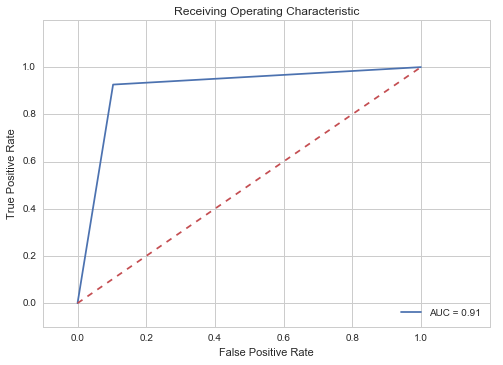

In [175]:
plt.title("Receiving Operating Characteristic")
plt.plot(false_positive_rate, true_positive_rate, 'b', 
        label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([-0.1,1.2])
plt.ylim([-0.1,1.2])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

One of the main tasks of the model is to understand what causes the driver to take their first trip. Analyzing the features for model fit might help us understand this better and come up with scenarios to increase their first trip rate.

In [176]:
importances = rf.feature_importances_

In [177]:
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

Features included in the model are..

In [178]:
X.columns

Index(['city_name', 'signup_os', 'signup_channel', 'days_bgc',
       'days_vehicle_added', 'Signed_up', 'Vehicle_added', 'BGC_done'],
      dtype='object')

These features are ranked based on model fit. This would explain which features more important in explaining how drivers take their first trip.

In [179]:
print("Feature ranking:")

xlabels = []

for f in range(X.shape[1]):
    print((X.columns[indices[f]]),importances[indices[f]])
    xlabels.append(X.columns[indices[f]])

Feature ranking:
days_vehicle_added 0.368272007415
Vehicle_added 0.303880440665
days_bgc 0.192319717756
BGC_done 0.0681434025445
signup_channel 0.0278416021267
signup_os 0.0275548749472
city_name 0.0119879545452
Signed_up 0.0


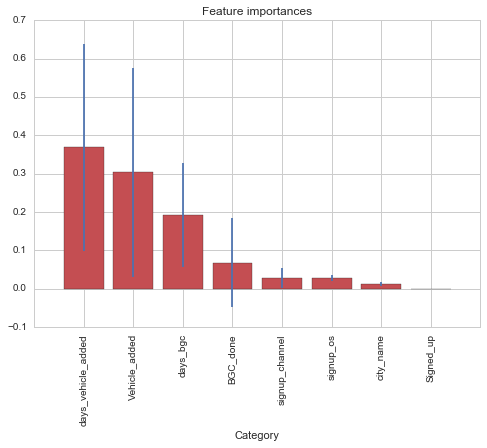

In [180]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), xlabels, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.xlabel('Category')
plt.show()

The model gives an intuitive result that drivers who have their background checks conducted and have added their vehicles, tend to take the first trip. This has a strong signal in the model as the AUC score is 0.914.

We can recall that I added two features for background check and vehicle added. One to identify whether these activities have an impact, and then I got the number of days (the difference of days from signup) as float type. This would give if the difference of days have an impact on drivers' first trip.

For this, we need to look at partial dependence plots, which available for gradient boosting algorithms in scikit learn.

The model is fit for the same training and test sets. Default parameters are used in the model fit.

In [181]:
clf = GradientBoostingClassifier(n_estimators=10).fit(X_train, y_train)
print("Training Accuracy: ", clf.score(X_train, y_train))
print("Test Accuracy: ", clf.score(X_test, y_test))

Training Accuracy:  0.931776723823
Test Accuracy:  0.930881263885


Both training and test scores are comparable, and above 0.9, so the model seems to be fit correctly.

Now, the partial dependence plots are explored for days taken to do background check and days taken to add vehicle.

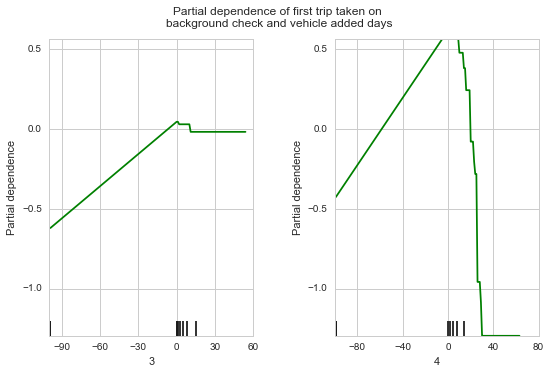

In [182]:
features = [3,4]
fig, axs = plot_partial_dependence(clf, X_train, features) 
fig.suptitle('Partial dependence of first trip taken on \n'
                 'background check and vehicle added days')
plt.subplots_adjust(top=0.9)

**It can be observed that the model has a strong signal or indication that the driver would take the first trip, when the difference between signup date and these dates are closer. The vehicle added date has more impact on the first trip.**

Now, I am going to remove these attributes from the model to understand if other features have an effect on the first trip. It was observed in the exploratory analysis that referred drivers tend to take the first trip more even though the paid drivers are more in the full dataset.

In [183]:
balanced_df.head()

,city_name,signup_os,signup_channel,days_bgc,days_vehicle_added,days_first_trip,Signed_up,Vehicle_added,BGC_done,Trip_taken
0,0,1,1,9.0,-99.0,-99.0,1,0,1,0
1,1,2,0,0.0,0.0,17.0,1,1,1,1
2,1,3,2,0.0,4.0,14.0,1,1,1,1
3,1,1,0,-99.0,45.0,-99.0,1,1,0,0
4,1,0,2,20.0,35.0,-99.0,1,1,1,0


In this reduced model, I removed all the date values, and let the model run based on city name, signup os and signup channel. Again, a random forest classifier is used for this.

In [184]:
X_mod = balanced_df.drop(balanced_df.columns[[3,4,5,6,7,8,9]], axis=1)
y_mod = balanced_df['Trip_taken']

In [185]:
X_train, X_test, y_train, y_test = train_test_split(X_mod, y_mod, test_size=0.33, random_state=42)

In [186]:
rf = RandomForestClassifier(n_estimators=100)

In [187]:
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [188]:
print("Training Accuracy: ", rf.score(X_train, y_train))
print("Test Accuracy: ", rf.score(X_train, y_train))

Training Accuracy:  0.649398029916
Test Accuracy:  0.649398029916


The accuracy is not great. But here, I am interested in knowing if any of these have an more impact amongst them on the first trip taken.

In [189]:
y_pred = np.array(rf.predict(X_test))
y_true = np.array(y_test)
#roc_auc_score(y_true, y_pred)

In [190]:
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

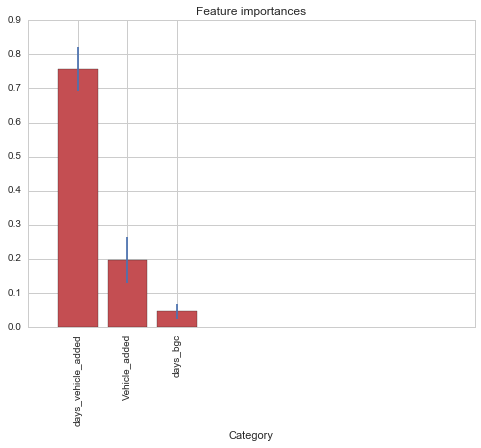

In [191]:
# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_mod.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X_mod.shape[1]), xlabels, rotation=90)
plt.xlim([-1, X.shape[1]])
plt.xlabel('Category')
plt.show()

This shows an important information that the signup-channel (paid, referred or organic) has a role in whether the driver takes the first trip or not. This confirms the discrepancy that we observed in the exploratory analysis that even though the paid drivers are more in the dataset, the referred drivers are the ones who take the first trip.

## Recommendations for higher first trip rate

Based on the model fit and exploratory analysis, here are the few things I would recommend to increase the first trip rate of drivers:

1. It looks like most paid drivers do not really end of taking the first trip. So, more analysis need to be done on why that is the case, if there are confounding factors and so on. If it is truly the case, this is the place we can cut the costs.
2. On the other hand, it looks like referred drivers tend to take their first trips. More effort could be put into this, for example, incentives could be given for referring people.
3. Drivers tend to take their first trip when the difference between their background check and vehicle added dates are closer to their signup dates. One could channel more effort to follow-up with drivers to do that.